In [0]:
!wget "https://d3c33hcgiwev3.cloudfront.net/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip?Expires=1549497600&Signature=DRIAyI57RQBaqZZtmoaZFBJSvaiIdN86a4bMFIz3vmwAw-MpLN~8YuTBMBkNdHeg3sxjx0KRMOydMNw0WvE5mWOi2I5pY0ncjIOOvHJghCT8IfbinclfkskptcUtvwMxmJ4V3nG9ToLQ4jo9NYCqnR5QvlQzDvdgx6dy6LFCabw_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"

In [0]:
!unzip -q LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip\?Expires\=1549497600\&Signature\=DRIAyI57RQBaqZZtmoaZFBJSvaiIdN86a4bMFIz3vmwAw-MpLN~8YuTBMBkNdHeg3sxjx0KRMOydMNw0WvE5mWOi2I5pY0ncjIOOvHJghCT8IfbinclfkskptcUtvwMxmJ

In [0]:
!ls

In [0]:
import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.color import gray2rgb

In [0]:
keypoints = pd.read_csv("facial-keypoints/data/gt.csv")

ind = 0
image_name = keypoints.iloc[ind, 0]
keypts = keypoints.iloc[ind, 1:].as_matrix()
keypts = keypts.astype('float').reshape(-1, 2)

In [0]:
def show_keypts(image, keypoints, ground_truth=None, ax=None):
    if ax:
        ax.imshow(image)
        ax.scatter(keypoints[:, 0], keypoints[:, 1], marker='o', c='red')  
        if ground_truth is not None:
            ax.scatter(ground_truth[:, 0], ground_truth[:, 1], marker='o', c='blue')  
        ax.grid(False)
    else:    
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], marker='o', c='red')
        plt.grid(False)

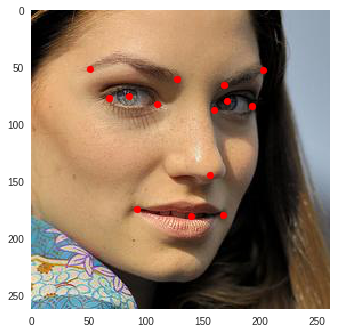

In [4]:
show_keypts(plt.imread(os.path.join("facial-keypoints/data/images", image_name)), keypts)

In [0]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointDataset(Dataset):
  
    def __init__(self, csv_file, root_dir, transform=None):

        self.keypoints = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.keypoints)

    def __getitem__(self, idx):

        image_name = self.keypoints.iloc[idx, 0]
        image_file = os.path.join(self.root_dir, image_name)

        img = plt.imread(image_file)
        if len(img.shape) == 2:
            img = gray2rgb(img)

        keypts = self.keypoints.iloc[idx, 1:].as_matrix()
        keypts = keypts.astype("float").reshape(-1, 2)

        sample = {"image": img, "keypoints": keypts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
csv_file = "facial-keypoints/data/gt.csv"
img_root_dir = "facial-keypoints/data/images"

face_dataset = FacialKeypointDataset(csv_file, img_root_dir)

print("Len of dataset: ", len(face_dataset))

Len of dataset:  6000


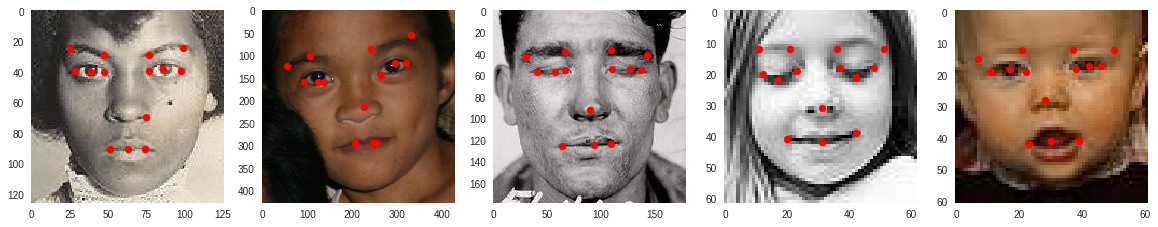

In [7]:
fig = plt.figure(figsize=(20, 10))

for i in range(5):
    idx = np.random.choice(len(face_dataset))
    sample = face_dataset[idx]
    ax = plt.subplot(1, 5, i+1)
    show_keypts(sample["image"], sample["keypoints"])

In [0]:
import torch
from torchvision import transforms, utils

class Normalize(object):

    def __call__(self, sample):

        image, keypts = sample["image"], sample["keypoints"]

        image_copy = image.copy()
        keypts_copy = keypts.copy()

        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
        image_copy = image_copy / 255.

        keypts_copy = (keypts_copy - 100) / 50

        return {"image": image_copy, "keypoints": keypts_copy}

In [0]:
class Rescale(object):
  
    def __init__(self, out_size):
        self.out_size = out_size

    def __call__(self, sample):

        image, keypts = sample["image"], sample["keypoints"]

        h, w = image.shape[:2]
        if h > w:
            new_h, new_w = self.out_size * h / w, self.out_size
        else:
            new_h, new_w = self.out_size, self.out_size * w / h

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        keypts = keypts * [new_w / w, new_h / h]

        return {"image": img, "keypoints": keypts}

In [0]:
class RandomCrop(object):
  
    def __init__(self, out_size):
        self.out_size = out_size

    def __call__(self, sample):

        image, keypts = sample["image"], sample["keypoints"]

        h, w = image.shape[:2]
        new_h, new_w = self.out_size, self.out_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top+new_h, left: left+new_w]
        keypts = keypts - [left, top]

        return {"image": image, "keypoints": keypts}

In [0]:
class ToTensor(object):

    def __call__(self, sample):

        image, keypts = sample["image"], sample["keypoints"]

        if len(image.shape) == 2:
            image = image.reshape(image.shape[0], image.shape[1], 1)

        image = np.transpose(image, [2, 0, 1])

        return {"image": torch.from_numpy(image).type(torch.FloatTensor),
                "keypoints": torch.from_numpy(keypts).type(torch.FloatTensor)}

In [12]:
sample["image"].shape

(61, 61, 3)

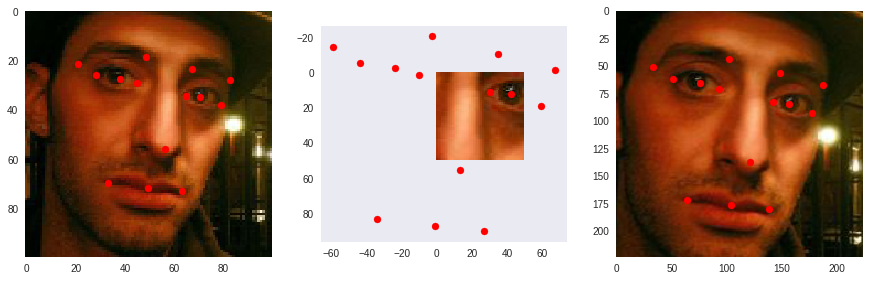

In [13]:
rescale = Rescale(100)
random_crop = RandomCrop(50)

transform = transforms.Compose([Rescale(250), RandomCrop(224)])

idx = 600
sample = face_dataset[idx]

fig = plt.figure(figsize=(15, 10))

for i, tr in enumerate([rescale, random_crop, transform]):
    transformed_sample = tr(sample)

    ax = plt.subplot(1, 3, i+1)
    show_keypts(transformed_sample["image"], transformed_sample["keypoints"])

plt.show()

In [0]:
transform = transforms.Compose([
    Rescale(250),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

transformed_dataset = FacialKeypointDataset(csv_file, img_root_dir, transform)

In [0]:
batch_size = 64
valid_size = 0.1

num_train = len(transformed_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[0:split], indices[split:]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(transformed_dataset, sampler=train_sampler, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(transformed_dataset, sampler=valid_sampler, batch_size=batch_size)

In [0]:
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

class Net(nn.Module):
  
    def __init__(self, input_size, out_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.out_size = out_size

        self.features = nn.Sequential(
            self._get_conv_block(1, 32),
            self._get_conv_block(32, 64),
            self._get_conv_block(64, 128)
        )
        self.conv_out_shape = self._get_conv_output(self.input_size)

        self.classifier = nn.Sequential(
            self._get_linear_block(self.conv_out_shape, 256, 0.4),
            self._get_linear_block(256, 512, 0.4),
            nn.Linear(512, 28)
        )
   
    def _get_conv_block(self, in_features, filter_size):
    
        conv_layer = nn.Sequential(
            nn.Conv2d(in_features, filter_size, kernel_size=3),
            nn.BatchNorm2d(filter_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        return conv_layer
  
    def _get_linear_block(self, in_features, n_units, prob):
    
        linear_layer = nn.Sequential(
            nn.Linear(in_features, n_units),
            nn.BatchNorm1d(n_units),
            nn.ReLU(),
            nn.Dropout2d(p=prob)
        )
        return linear_layer
  
  
    def _get_conv_output(self, shape):
        bs = batch_size
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x):
        return self.features(x)


    def forward(self, X):
        X = self.features(X)
        X = X.view(X.size(0), -1)
        out = self.classifier(X)
        return out

In [17]:
input_size = transformed_dataset[1]["image"].size()
out_size = 28

net = Net(input_size, out_size)
print(net)

Net(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Sequential(
      (0): Linear(in_features=86528, out_features=256, bias=True)


In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [19]:
n_epochs = 50
training_loss = []
validation_loss = []


for epoch in range(n_epochs):
    running_loss = 0
    running_val_loss = 0

    net.train()

    for data in train_loader:
        images = data["image"]
        keypoints = data["keypoints"]
        keypoints = keypoints.view(keypoints.size(0), -1)

        images, keypoints = images.to(device), keypoints.to(device)
        logits = net(images)

        optimizer.zero_grad()
        loss = criterion(logits, keypoints)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    else:
        with torch.no_grad():
            net.eval()
            for data in valid_loader:
                
                images = data["image"]
                keypoints = data["keypoints"]
                keypoints = keypoints.view(keypoints.size(0), -1)
                images, keypoints = images.to(device), keypoints.to(device)

                logits = net(images)

                loss = criterion(logits, keypoints)
                running_val_loss += loss.item()        

        running_val_loss /= len(valid_loader)
        running_loss /= len(train_loader)

        training_loss.append(running_loss)
        validation_loss.append(running_val_loss)
        print("Epoch: {} \t Train Loss: {:.3f} \t Valid Loss: {:.3f}".format(epoch+1, running_loss, running_val_loss))

Epoch: 1 	 Train Loss: 0.528 	 Valid Loss: 0.476
Epoch: 2 	 Train Loss: 0.192 	 Valid Loss: 0.328
Epoch: 3 	 Train Loss: 0.161 	 Valid Loss: 0.284
Epoch: 4 	 Train Loss: 0.128 	 Valid Loss: 0.204
Epoch: 5 	 Train Loss: 0.114 	 Valid Loss: 0.139
Epoch: 6 	 Train Loss: 0.102 	 Valid Loss: 0.113
Epoch: 7 	 Train Loss: 0.094 	 Valid Loss: 0.102
Epoch: 8 	 Train Loss: 0.096 	 Valid Loss: 0.096
Epoch: 9 	 Train Loss: 0.087 	 Valid Loss: 0.098
Epoch: 10 	 Train Loss: 0.083 	 Valid Loss: 0.093
Epoch: 11 	 Train Loss: 0.080 	 Valid Loss: 0.087
Epoch: 12 	 Train Loss: 0.078 	 Valid Loss: 0.091
Epoch: 13 	 Train Loss: 0.079 	 Valid Loss: 0.080
Epoch: 14 	 Train Loss: 0.080 	 Valid Loss: 0.084
Epoch: 15 	 Train Loss: 0.078 	 Valid Loss: 0.083
Epoch: 16 	 Train Loss: 0.073 	 Valid Loss: 0.082
Epoch: 17 	 Train Loss: 0.068 	 Valid Loss: 0.085
Epoch: 18 	 Train Loss: 0.067 	 Valid Loss: 0.084
Epoch: 19 	 Train Loss: 0.066 	 Valid Loss: 0.084
Epoch: 20 	 Train Loss: 0.062 	 Valid Loss: 0.079
Epoch: 21

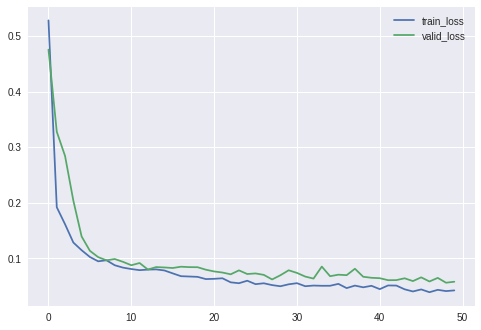

In [20]:
plt.plot(np.arange(n_epochs), training_loss, label="train_loss")
plt.plot(np.arange(n_epochs), validation_loss, label="valid_loss")

plt.legend()
plt.show()

In [0]:
torch.save(net.state_dict(), "model.pt")
# net.load_state_dict(torch.load("model.pt"))

In [0]:
valid_sample = next(iter(valid_loader)) 
preds = net(valid_sample['image'].to(device))
ground_truth_keypts = valid_sample["keypoints"].data.numpy().reshape(-1, 2)
predicted_keypts = preds.cpu().detach().numpy().reshape(-1, 2)

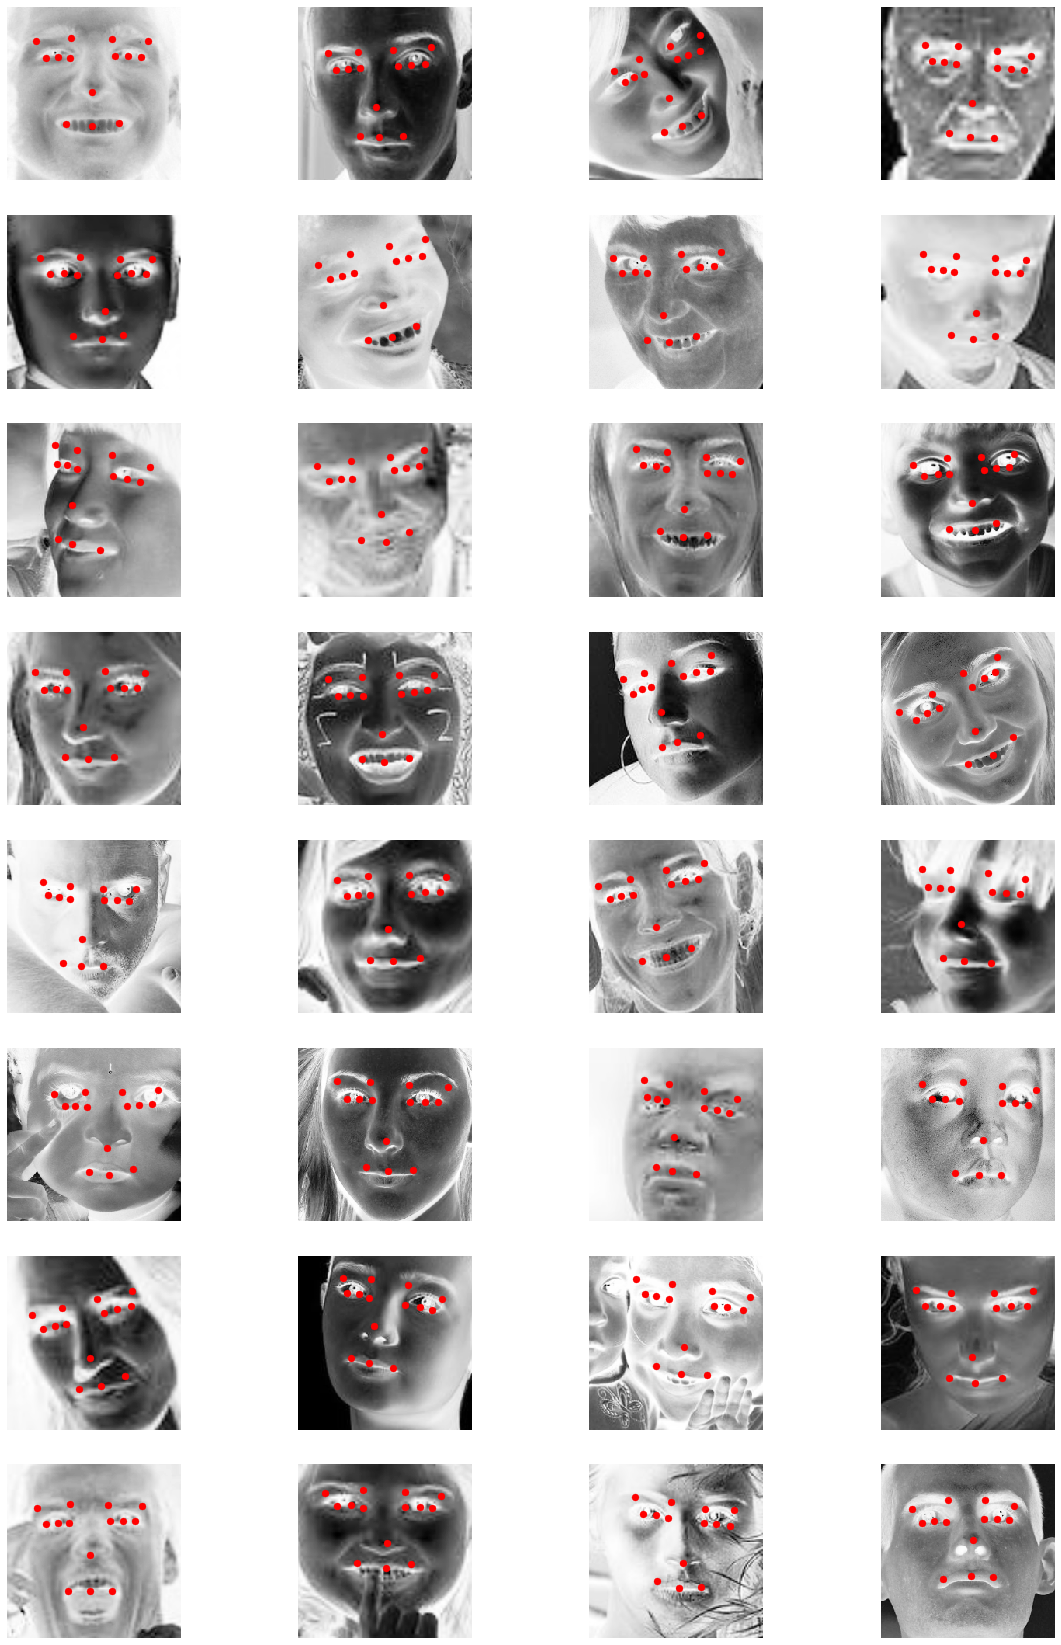

In [23]:
def show_test_imgs(test_imgs, ground_truth_keypts, predicted_keypts):

    fig = plt.figure(figsize=(20, 30))
    current = 0
    for i in range(32):

        img = test_imgs["image"][i].data
        img = img.numpy().transpose([1, 2, 0])
        ax = fig.add_subplot(8, 4, i+1, xticks=[], yticks=[])

        show_keypts(img[:, :, 0], predicted_keypts[current:current+14, :] * 50 + 100, ax)
        # If want to show ground truth labels too. 
        #     show_keypts(img[:, :, 0], predicted_keypts[current:current+14, :] * 50 + 100, 
        #                 ground_truth_keypts[current:current+14, :] * 50 + 100, ax)
        current += 14

    plt.show()

show_test_imgs(valid_sample, ground_truth_keypts, predicted_keypts)